# Imports We Will Use

In [2]:
import math
import random
from dataclasses import dataclass


# Data + numeric
import numpy as np
import pandas as pd

# Saving / paths
from pathlib import Path

#Progress bar
from tqdm import tqdm

# Visualisation
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score



# Generate Data
- Generates the data with features of each aircraft - and thier intent (which will be hidden from the model)

## Functions to Generate Feature
- All the functions to generate the features that define an aircraft

In [3]:
THREAT_TO_P = {
    "PEACE": 0.001,
    "TENSION":0.01,
    "CRISIS": 0.05
}

def determine_intent(p_enemy:float)->int:
    """0: Is civilian aircraft
       1: Is enemy aircraft"""
    return 1 if random.random() < p_enemy else 0


def clamp01(x:float)->float:
    """Force values to stay inside [0.0, 1.0]."""
    return max(0.0, min(1.0,x))

def determine_distance(noise: float = 0.02)->float:
    """
    - Base distance is uniform: every distance is equally likely for both civilian and enemy.
    - We add small measurement noise to mimic radar imperfectoins
    - We clamp back into [0,1] so normalization is never broken
    """
    x = random.random()   #Pick base distance
    x+=random.uniform(-noise, noise)
    return clamp01(x)


def determine_angles() -> tuple[float, float]:
    """Returns (sin(theta), cos(theta)) for a random bearing theta."""
    theta = random.uniform(0.0, 2 * math.pi)
    return math.sin(theta), math.cos(theta)
    

def determine_speed(is_enemy: int) -> float:
    if is_enemy == 0:
        return random.uniform(0.2, 0.7)  # civilians can be fast sometimes
    else:
        return random.uniform(0.4, 0.9)  # enemies can be slower sometimes
    
    
def determine_acceleration(is_enemy: int) -> float:
    # Civilians mostly low accel; enemies wider range but can also be calm sometimes
    if is_enemy == 0:
        return random.uniform(0.0, 0.12)
    else:
        return random.uniform(0.0, 1.0)  # includes "stealth" low-accel cases too
    

def determine_turn_rate(is_enemy: int) -> float:
    # Avoid a clean threshold. Make overlap large.
    if is_enemy == 0:
        return random.uniform(0.0, 0.40)  # training/patrol can turn a lot
    else:
        return random.uniform(0.10, 1.0)  # stealth can be low-ish too


def determine_heading_to_city(is_enemy:int)->float:
    if is_enemy == 0:
        return random.uniform(0.0, 0.7)
    else:
        return random.uniform(0.4, 1.0)   
    
    
def determine_loiter_score(is_enemy: int) -> float:
    # Slight tendency: enemies recon loiter more; civilians mostly transit, but can loiter
    if is_enemy == 0:
        return random.uniform(0.0, 0.8)
    else:
        return random.uniform(0.2, 1.0)
    

def determine_in_corridor(is_enemy: int) -> int:
    """
    Returns 1 if in corridor else 0.

    Civilians: usually in corridor (e.g. 90%).
    Enemies: sometimes blend in corridor (e.g. 30%).
    """
    p_in_corridor = 0.90 if is_enemy == 0 else 0.30
    return 1 if random.random() < p_in_corridor else 0


def determine_in_restricted_zone(is_enemy: int) -> int:
    p = 0.01 if is_enemy == 0 else 0.25
    return 1 if random.random() < p else 0

def determine_transponder_present(is_enemy: int) -> int:
    p_present = 0.97 if is_enemy == 0 else 0.35
    return 1 if random.random() < p_present else 0

def determine_transponder_valid(is_enemy: int, transponder_present: int) -> int:
    if transponder_present == 0:
        return 0
    p_valid = 0.98 if is_enemy == 0 else 0.40
    return 1 if random.random() < p_valid else 0

def determine_transponder_stability(is_enemy: int, transponder_present: int) -> float:
    """
    Returns signal stability in [0,1].

    1.0 = perfectly stable
    0.0 = constantly dropping

    If transponder is absent -> stability is 0 by definition.
    """
    if transponder_present == 0:
        return 0.0

    if is_enemy == 0:
        # Civilians: usually very stable, rare faults
        return random.uniform(0.7, 1.0)
    else:
        # Enemies: spoofing / intermittent signals
        return random.uniform(0.0, 0.7)

def determine_rcs_norm(is_enemy: int) -> float:
    r = random.random()
    if is_enemy == 0:
        x = random.uniform(0.45, 1.00) if r < 0.80 else random.uniform(0.15, 0.55)
    else:
        x = random.uniform(0.05, 0.65) if r < 0.80 else random.uniform(0.40, 0.95)
    return clamp01(x)




## Generating the data
- Generate training data 300K rows
- Generate validation data 60K rows
- Generate testing data 60K rows

### Generate Training Data

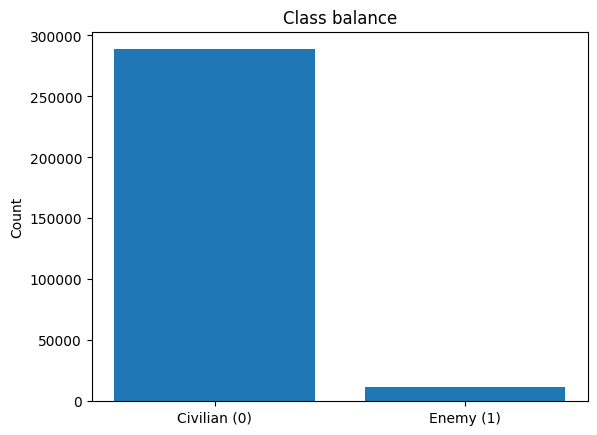

Enemy aircraft count: 11394
Civilian aircraft count: 288606


In [4]:
rows = []

p_crisis  = THREAT_TO_P["CRISIS"]
p_tension = THREAT_TO_P["TENSION"]

for i in range(1, 300_000 + 1):
    # 70% crisis, 30% tension
    p_enemy = p_crisis if i <= 210_000 else p_tension

    is_enemy = determine_intent(p_enemy)

    transponder_present = determine_transponder_present(is_enemy)

    row = {}
    row["track_id"] = f"AC_{i}"
    row["distance"] = determine_distance()
    row["angle_sin"], row["angle_cos"] = determine_angles()
    row["speed"] = determine_speed(is_enemy)
    row["acceleration"] = determine_acceleration(is_enemy)
    row["turn_rate"] = determine_turn_rate(is_enemy)
    row["heading_to_city"] = determine_heading_to_city(is_enemy)
    row["loiter_score"] = determine_loiter_score(is_enemy)
    row["in_corridor"] = determine_in_corridor(is_enemy)
    row["in_restricted_zone"] = determine_in_restricted_zone(is_enemy)
    row["transponder_present"] = transponder_present
    row["transponder_valid"] = determine_transponder_valid(is_enemy, transponder_present)
    row["transponder_stability"] = determine_transponder_stability(is_enemy, transponder_present)
    row["rcs"] = determine_rcs_norm(is_enemy)
    row["is_enemy"] = is_enemy

    rows.append(row)

df_train = pd.DataFrame(rows)

df_train.to_csv("radar_train.csv", index=False)

enemy_count = (df_train["is_enemy"] == 1).sum()
civilian_count = (df_train["is_enemy"] == 0).sum()

# Visualising the data 
counts = df_train["is_enemy"].value_counts().sort_index()
plt.bar(["Civilian (0)", "Enemy (1)"], counts.values)
plt.title("Class balance")
plt.ylabel("Count")
plt.show()

print(f"Enemy aircraft count: {enemy_count}")
print(f"Civilian aircraft count: {civilian_count}")


### Generating Validation Data

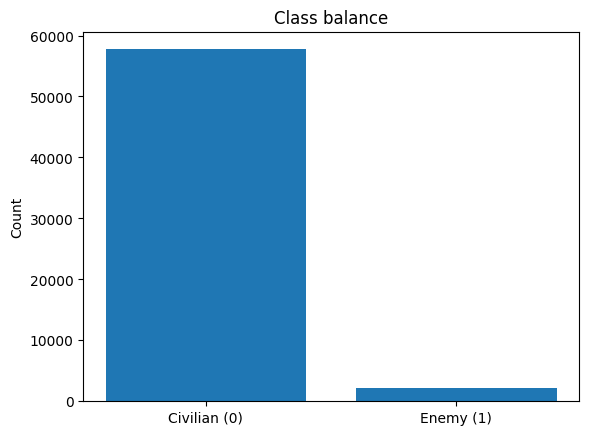

Enemy aircraft count: 2258
Civilian aircraft count: 57742


In [5]:
#Train: 70% CRISIS, 30% TENSION

#Validation: 70% CRISIS, 30% TENSION

#Test: 60% PEACE, 30% TENSION, 10% CRISIS


rows = []

p_crisis  = THREAT_TO_P["CRISIS"]
p_tension = THREAT_TO_P["TENSION"]

for i in range(1, 60_000 + 1):
    # 70% crisis, 30% tension
    p_enemy = p_crisis if i <= 42_000 else p_tension

    is_enemy = determine_intent(p_enemy)

    transponder_present = determine_transponder_present(is_enemy)

    row = {}
    row["track_id"] = f"AC_{i}"
    row["distance"] = determine_distance()
    row["angle_sin"], row["angle_cos"] = determine_angles()
    row["speed"] = determine_speed(is_enemy)
    row["acceleration"] = determine_acceleration(is_enemy)
    row["turn_rate"] = determine_turn_rate(is_enemy)
    row["heading_to_city"] = determine_heading_to_city(is_enemy)
    row["loiter_score"] = determine_loiter_score(is_enemy)
    row["in_corridor"] = determine_in_corridor(is_enemy)
    row["in_restricted_zone"] = determine_in_restricted_zone(is_enemy)
    row["transponder_present"] = transponder_present
    row["transponder_valid"] = determine_transponder_valid(is_enemy, transponder_present)
    row["transponder_stability"] = determine_transponder_stability(is_enemy, transponder_present)
    row["rcs"] = determine_rcs_norm(is_enemy)
    row["is_enemy"] = is_enemy

    rows.append(row)

df_val = pd.DataFrame(rows)

df_val.to_csv("radar_validation.csv", index=False)

enemy_count = (df_val["is_enemy"] == 1).sum()
civilian_count = (df_val["is_enemy"] == 0).sum()

# Visualising the data 
counts = df_val["is_enemy"].value_counts().sort_index()
plt.bar(["Civilian (0)", "Enemy (1)"], counts.values)
plt.title("Class balance")
plt.ylabel("Count")
plt.show()

print(f"Enemy aircraft count: {enemy_count}")
print(f"Civilian aircraft count: {civilian_count}")



### Generate Testing Data

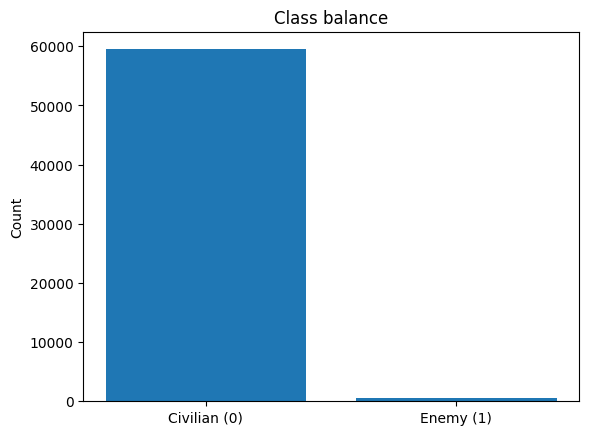

Enemy aircraft count: 522
Civilian aircraft count: 59478


In [6]:

#Test: 60% PEACE, 30% TENSION, 10% CRISIS


rows = []

p_crisis  = THREAT_TO_P["CRISIS"]
p_tension = THREAT_TO_P["TENSION"]
p_peace = THREAT_TO_P["PEACE"]


for i in range(1, 60_000 + 1):
    # 70% crisis, 30% tension
    if i < 36000:
        p_enemy = p_peace
    elif i < 54000:
        p_enemy = p_tension
    else:
        p_enemy = p_crisis
        
    is_enemy = determine_intent(p_enemy)

    transponder_present = determine_transponder_present(is_enemy)

    row = {}
    row["track_id"] = f"AC_{i}"
    row["distance"] = determine_distance()
    row["angle_sin"], row["angle_cos"] = determine_angles()
    row["speed"] = determine_speed(is_enemy)
    row["acceleration"] = determine_acceleration(is_enemy)
    row["turn_rate"] = determine_turn_rate(is_enemy)
    row["heading_to_city"] = determine_heading_to_city(is_enemy)
    row["loiter_score"] = determine_loiter_score(is_enemy)
    row["in_corridor"] = determine_in_corridor(is_enemy)
    row["in_restricted_zone"] = determine_in_restricted_zone(is_enemy)
    row["transponder_present"] = transponder_present
    row["transponder_valid"] = determine_transponder_valid(is_enemy, transponder_present)
    row["transponder_stability"] = determine_transponder_stability(is_enemy, transponder_present)
    row["rcs"] = determine_rcs_norm(is_enemy)
    row["is_enemy"] = is_enemy

    rows.append(row)

df_test = pd.DataFrame(rows)

df_test.to_csv("radar_testing.csv", index=False)

enemy_count = (df_test["is_enemy"] == 1).sum()
civilian_count = (df_test["is_enemy"] == 0).sum()

# Visualising the data 
counts = df_test["is_enemy"].value_counts().sort_index()
plt.bar(["Civilian (0)", "Enemy (1)"], counts.values)
plt.title("Class balance")
plt.ylabel("Count")
plt.show()

print(f"Enemy aircraft count: {enemy_count}")
print(f"Civilian aircraft count: {civilian_count}")



# Sanity Check
- Check if the data captured makes sense and there are no errors !

In [7]:
LABEL_COL = "is_enemy"
ID_COL = "track_id"   # string ID column (not a feature)

SAVE_REPORT = True
REPORT_PATH = "part2_sanity_report.json"

# 0) Quick sanity: make sure label exists
for name, df in [("train", df_train), ("val", df_val), ("test", df_test)]:
    if LABEL_COL not in df.columns:
        raise ValueError(f"{name} is missing label column '{LABEL_COL}'. Found: {df.columns.tolist()}")

print("✅ Label column found:", LABEL_COL)

# 1) Column consistency
print("\n=== COLUMN CHECK ===")
assert list(df_train.columns) == list(df_val.columns) == list(df_test.columns), \
    "❌ Column mismatch across train / val / test"
print("✅ Columns match across all splits")

# 2) Basic integrity checks
def integrity_report(df, name):
    numeric = df.select_dtypes(include=[np.number])
    return {
        "split": name,
        "shape": df.shape,
        "missing_cells_total": int(df.isna().sum().sum()),
        "infinite_values_total": int(np.isinf(numeric.to_numpy()).sum()) if numeric.shape[1] else 0,
        "duplicate_rows": int(df.duplicated().sum()),
        "label_counts": df[LABEL_COL].value_counts().to_dict(),
        "label_ratio": df[LABEL_COL].value_counts(normalize=True).to_dict()
    }

train_integrity = integrity_report(df_train, "train")
val_integrity   = integrity_report(df_val,   "val")
test_integrity  = integrity_report(df_test,  "test")

print("\n=== INTEGRITY SUMMARY ===")
for r in [train_integrity, val_integrity, test_integrity]:
    print(f"\n[{r['split'].upper()}]")
    print("shape:", r["shape"])
    print("missing cells:", r["missing_cells_total"])
    print("infinite values:", r["infinite_values_total"])
    print("duplicate rows:", r["duplicate_rows"])
    print("label ratio:", r["label_ratio"])

# 3) Feature range checks (numeric only, excluding label + ID)
print("\n=== FEATURE RANGE CHECK (TRAIN) ===")
feature_cols = [c for c in df_train.columns if c not in {LABEL_COL, ID_COL}]
numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_train[c])]

feature_stats = {}
for col in numeric_cols:
    s = df_train[col].replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) == 0:
        continue
    feature_stats[col] = {
        "min": float(s.min()),
        "max": float(s.max()),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=0)),
    }
    print(f"{col:25s} | min={s.min():.4f} max={s.max():.4f} mean={s.mean():.4f}")

print(f"\nChecked {len(feature_stats)} numeric features")

# 4) Class-conditional mean difference (how much each feature separates classes)
print("\n=== CLASS-CONDITIONAL MEAN DIFFERENCE (TRAIN) ===")
class_mean_diff = {}
for col in numeric_cols:
    m0 = df_train.loc[df_train[LABEL_COL] == 0, col].mean()
    m1 = df_train.loc[df_train[LABEL_COL] == 1, col].mean()
    diff = float(abs(m1 - m0))
    class_mean_diff[col] = diff

# Show top 10 most separating features
top = sorted(class_mean_diff.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 features by |mean(enemy)-mean(civilian)|:")
for col, diff in top:
    print(f"{col:25s} | Δmean={diff:.6f}")

# 5) Leakage smell-test baseline (Logistic Regression)
print("\n=== LEAKAGE SMELL TEST (LogReg baseline on VAL) ===")

# Drop ID (track_id) + label
X_train = df_train.drop(columns=[LABEL_COL, ID_COL], errors="ignore")
y_train = df_train[LABEL_COL].astype(int)

X_val = df_val.drop(columns=[LABEL_COL, ID_COL], errors="ignore")
y_val = df_val[LABEL_COL].astype(int)

# Handle NaN/Inf in a simple baseline way (median fill based on TRAIN)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
medians = X_train.median(numeric_only=True)
X_train = X_train.fillna(medians)

X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(medians)

baseline = LogisticRegression(max_iter=300, n_jobs=-1)
baseline.fit(X_train, y_train)

val_pred = baseline.predict(X_val)
val_prob = baseline.predict_proba(X_val)[:, 1]

cm = confusion_matrix(y_val, val_pred)
auc = roc_auc_score(y_val, val_prob)

print("\nConfusion Matrix (VAL):")
print(cm)

print("\nClassification Report (VAL):")
print(classification_report(y_val, val_pred, digits=4))

print(f"ROC-AUC (VAL): {auc:.4f}")

print("\n⚠️ If these results are near-perfect, you likely have leakage or the dataset is too easy.")

# 6) Save report (optional)
if SAVE_REPORT:
    report = {
        "integrity": {"train": train_integrity, "val": val_integrity, "test": test_integrity},
        "feature_stats_train": feature_stats,
        "class_mean_diff_train": class_mean_diff,
        "baseline_logreg": {
            "confusion_matrix_val": cm.tolist(),
            "roc_auc_val": float(auc),
        },
    }
    with open(REPORT_PATH, "w", encoding="utf-8") as f:
        json.dump(report, f, indent=2)
    print(f"\n📄 Saved report to: {REPORT_PATH}")


✅ Label column found: is_enemy

=== COLUMN CHECK ===
✅ Columns match across all splits



=== INTEGRITY SUMMARY ===

[TRAIN]
shape: (300000, 16)
missing cells: 0
infinite values: 0
duplicate rows: 0
label ratio: {0: 0.96202, 1: 0.03798}

[VAL]
shape: (60000, 16)
missing cells: 0
infinite values: 0
duplicate rows: 0
label ratio: {0: 0.9623666666666667, 1: 0.03763333333333333}

[TEST]
shape: (60000, 16)
missing cells: 0
infinite values: 0
duplicate rows: 0
label ratio: {0: 0.9913, 1: 0.0087}

=== FEATURE RANGE CHECK (TRAIN) ===
distance                  | min=0.0000 max=1.0000 mean=0.4999
angle_sin                 | min=-1.0000 max=1.0000 mean=0.0007
angle_cos                 | min=-1.0000 max=1.0000 mean=-0.0002
speed                     | min=0.2000 max=0.9000 mean=0.4576
acceleration              | min=0.0000 max=0.9999 mean=0.0767
turn_rate                 | min=0.0000 max=1.0000 mean=0.2132
heading_to_city           | min=0.0000 max=0.9999 mean=0.3631
loiter_score              | min=0.0000 max=0.9997 mean=0.4077
in_corridor               | min=0.0000 max=1.0000 mean=0.8

c:\Users\F8884841\OneDrive - FRG\Desktop\PythonProjects\radar-system-neural-network\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



Confusion Matrix (VAL):
[[57729    13]
 [   37  2221]]

Classification Report (VAL):
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     57742
           1     0.9942    0.9836    0.9889      2258

    accuracy                         0.9992     60000
   macro avg     0.9968    0.9917    0.9942     60000
weighted avg     0.9992    0.9992    0.9992     60000

ROC-AUC (VAL): 1.0000

⚠️ If these results are near-perfect, you likely have leakage or the dataset is too easy.

📄 Saved report to: part2_sanity_report.json
